In [1]:
from fastai.vision.all import *
from fastai.data.all import *

/home/ubuntu/.virtualenvs/magnetic-tiles-defect-clR5l9w5/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_NAME = 'MAGNETIC_TILE_SURFACE_DEFECTS'
CODE_NAMES = [0, 1]

PROJ_PATH = Path.cwd().parent
DATASET_PATH = PROJ_PATH/'data'/DATASET_NAME
print(PROJ_PATH)
print(DATASET_PATH)


/home/ubuntu/magnetic-tiles-defect
/home/ubuntu/magnetic-tiles-defect/data/MAGNETIC_TILE_SURFACE_DEFECTS


In [3]:
train_fpaths = get_image_files(DATASET_PATH/'train_images')
test_fpaths = get_image_files(DATASET_PATH/'test_images')
len(train_fpaths), len(test_fpaths)

(314, 78)

In [4]:
def get_mask_path(img_path): 
    msk_path = Path(str(img_path.parent).replace('_images', '_masks'))/f'{img_path.stem}.png'
    return msk_path

get_mask_path(test_fpaths[0])

Path('/home/ubuntu/magnetic-tiles-defect/data/MAGNETIC_TILE_SURFACE_DEFECTS/test_masks/exp1_num_284482.png')

In [5]:
sz = 224
item_tfms_sz = sz
batch_tfms_sz = sz
item_tfms_sz, batch_tfms_sz

(224, 224)

In [6]:
str(Path(train_fpaths[0]).parent.name).startswith('train')

True

/home/ubuntu/.virtualenvs/magnetic-tiles-defect-clR5l9w5/lib/python3.8/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


TensorImage(-2.0219, device='cuda:0') TensorImage(2.6262, device='cuda:0')
TensorMask(0, device='cuda:0') TensorMask(1, device='cuda:0')


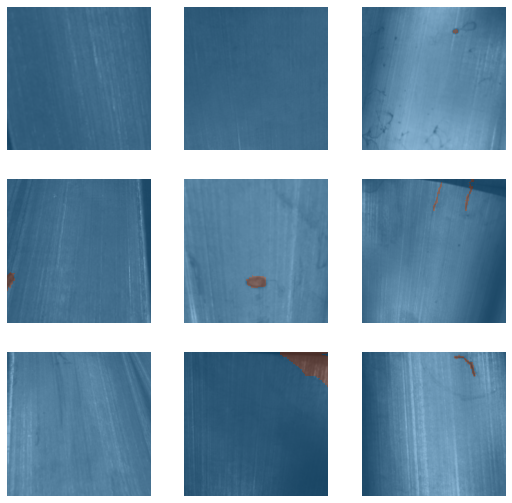

In [7]:
dls = SegmentationDataLoaders.from_label_func(
    path=DATASET_PATH, 
    fnames=train_fpaths + test_fpaths,
    label_func=get_mask_path,
    codes=CODE_NAMES,
    bs=16, 
    splitter=FuncSplitter(lambda o: str(Path(o).parent.name).startswith('test')),
    item_tfms = Resize(item_tfms_sz),
    batch_tfms =[*aug_transforms(size=batch_tfms_sz), 
                 Normalize.from_stats(*imagenet_stats)]
)

#dls.device = 'cpu' # uncomment to use CPU, might take longer to train

dls.show_batch()
batch = dls.one_batch()
print(batch[0].min(), batch[0].max())
print(batch[1].min(), batch[1].max())

In [8]:
len(dls.train_ds), len(dls.valid_ds), len(dls.train_ds) + len(dls.valid_ds)

(314, 78, 392)

In [9]:
metrics = [DiceMulti]  

In [10]:
model_dir = PROJ_PATH/'models'
model_dir.mkdir(exist_ok=True)
pickle_fpath = model_dir/'model_pickle_fastai.pkl'
pickle_fpath

Path('/home/ubuntu/magnetic-tiles-defect/models/model_pickle_fastai.pkl')

In [11]:
learn = unet_learner(dls, resnet34, metrics=metrics)

learn.fine_tune(15)
learn.export(fname=pickle_fpath)

epoch,train_loss,valid_loss,dice_multi,time
0,0.607189,0.408745,0.467134,00:15


epoch,train_loss,valid_loss,dice_multi,time
0,0.289294,0.361580,0.467134,00:11
1,0.269208,0.270112,0.467134,00:11
2,0.265515,0.238757,0.467134,00:11
3,0.236735,0.179406,0.745577,00:11
4,0.224196,0.179855,0.872025,00:11
5,0.195686,0.218827,0.731565,00:11
6,0.181970,0.114315,0.906745,00:11
7,0.158952,0.104107,0.915151,00:11
8,0.135146,0.077450,0.935867,00:11
9,0.121207,0.075397,0.936465,00:11


In [12]:
learn.export(fname=pickle_fpath)

/home/ubuntu/.virtualenvs/magnetic-tiles-defect-clR5l9w5/lib/python3.8/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


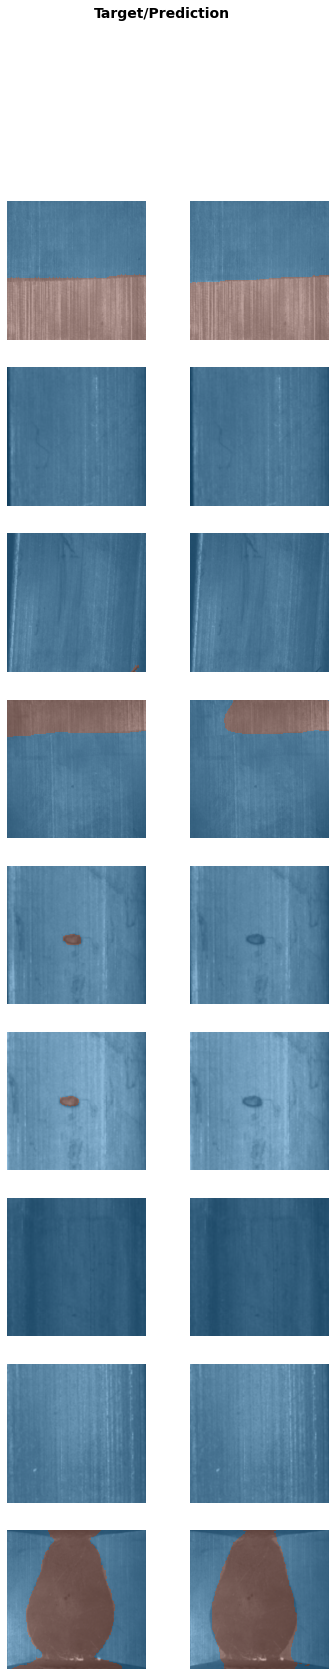

In [13]:
learn.show_results()

In [14]:
loss_val, dice_val = learn.validate()
loss_val, dice_val

(0.06318951398134232, 0.9407915873488055)

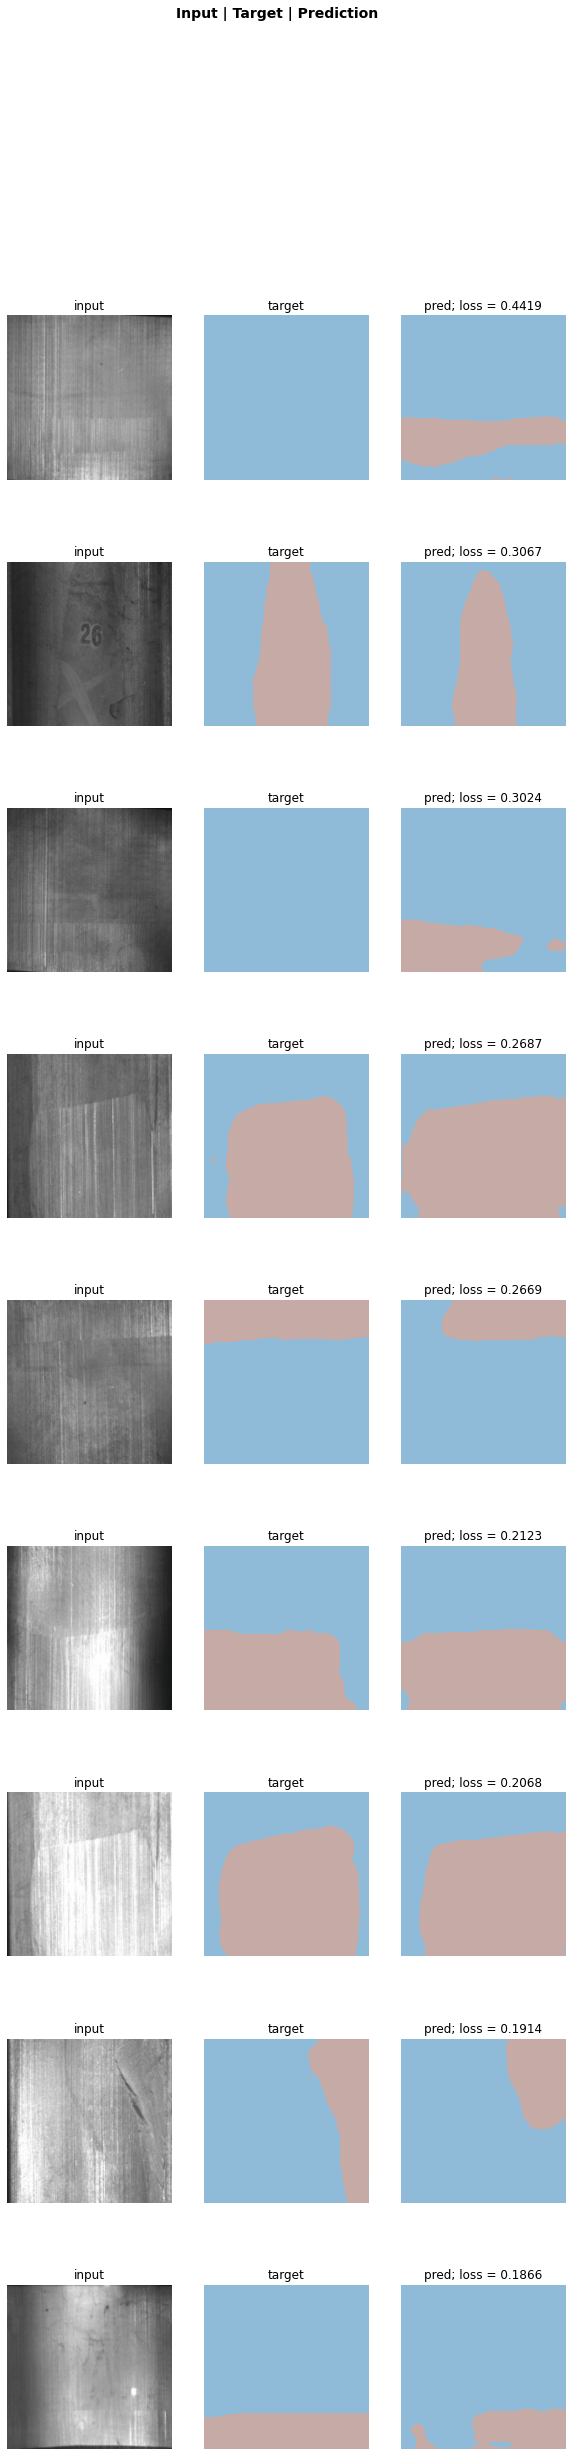

In [15]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(10,figsize=(10,40))